In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import random_statevector
from qiskit.extensions import Initialize
import qiskit.quantum_info as qi
from qiskit.tools.monitor import job_monitor

import numpy as np



<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def ent_swapping():
    qr=QuantumRegister(3)
    qc=QuantumCircuit(qr)
    
    qc.cx(qr[0],qr[1])
    qc.h(qr[0])
    
    qc.cx(qr[1],qr[2])
    qc.cz(qr[0],qr[2])
    ins= qc.to_instruction()
    ins.name="ent swap"
    
    return ins 

def add_all_es(l,qc):
    li = l[1:]
    r = li[0]    
    li = li[1:]
    for i,j in zip(li[0::2],li[1::2]):
        #print(r,i,j)
        qc.append(ent_swapping(),[r,i,j])
        r = j

In [3]:
class generalized_repeater:
    def __init__(self,nodes):
        self.nodes=2*nodes+2
        self.qc=QuantumCircuit(self.nodes,1)
        self.init_state=0
        self.qc
        l=[i for i in range(0,self.nodes)]
        self.add_all_ent(l)
        add_all_es(l,self.qc)

    def add_all_ent(self,l):
        for i,j in zip(l[0::2],l[1::2]):
            #print(i,j)
            self.create_ent(i,j)

    def add_ent_swapping(self,r_a,r_b,b):
        self.qc.append(ent_swapping(),[r_a,r_b,b])
        return self.qc

    def prepare_random_state(self,random=0,state=[1,0]):
        if(random!=0):
            psi= random_statevector(2)
            init_state = Initialize(psi)
        else:
             init_state = Initialize(state)
                
        self.init_state=init_state
        self.qc.append(init_state,[self.nodes])
        self.qc.barrier()
        return self.qc

    def prepare_specicfic_state(self,state):
        self.qc.initialize(state,0)

    def add_inverse(self, ):
        self.qc.append(self.init_state.gates_to_uncompute(),[self.nodes-1])

    def draw(self):
        return self.qc.draw()

    def get_circuit(self):
        return self.qc

    def create_ent(self,a,b):
        self.qc.h(a)
        self.qc.cx(a,b)

    def get_nodes(self):
        return self.nodes

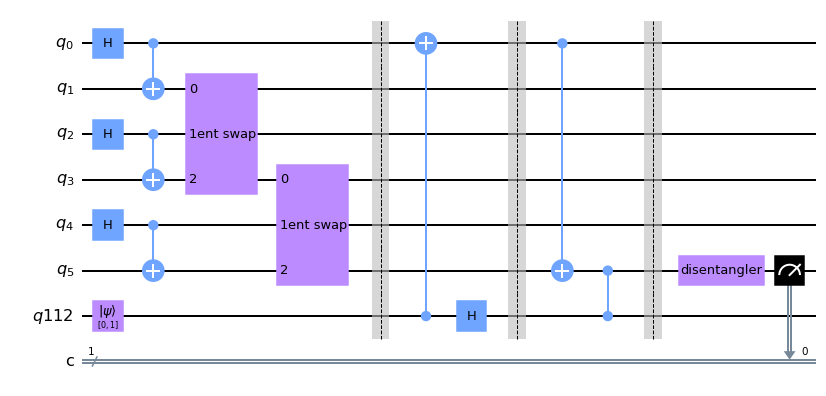

In [14]:
c=generalized_repeater(2)
circuit = c.get_circuit()
circuit.draw()

psi=QuantumRegister(1)
circuit.add_register(psi)

c.prepare_random_state(0,[0,1])
circuit.cx(c.get_nodes(),0)
circuit.h(c.get_nodes())
circuit.barrier()
circuit.cx(0,c.get_nodes()-1)
circuit.cz(c.get_nodes(),c.get_nodes()-1)
circuit.barrier()
c.add_inverse()
circuit.measure(c.get_nodes()-1,0)
circuit.draw()

Aer simulator

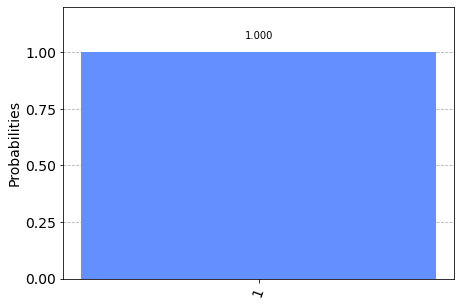

In [12]:
sim=Aer.get_backend('aer_simulator')

t_qc = transpile(c.get_circuit(), sim)
result=sim.run(t_qc).result()
counts=result.get_counts()
plot_histogram(counts)

Naerobi System

ibmqfactory.load_account:WARNING:2022-07-25 12:13:37,486: Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


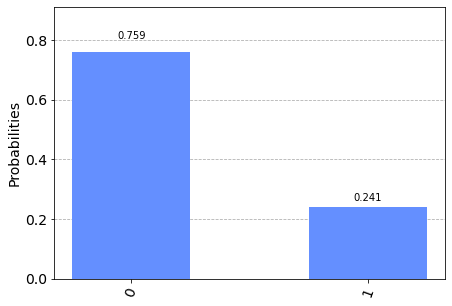

In [15]:
# Loading your IBM Quantum account(s)
IBMQ.load_account()
IBMQ.providers()
provider=IBMQ.get_provider('ibm-q')
sim2= provider.get_backend('ibm_nairobi')


t_qc2 = transpile(c.get_circuit(), sim2)
job_real2=sim2.run(t_qc2)
job_monitor(job_real2)
result2= job_real2.result()
counts=result2.get_counts()
plot_histogram(counts)